In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import numpy.linalg as LA
from sklearn import datasets, svm, metrics

In [ ]:
CONV1 = 64
CONV2 = 128
DENSE = 128
DROPOUT = 0.1

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Connect GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls gdrive/MyDrive/CSC2515_Project/data/out

test  train  valid


In [ ]:
# setting data paths
ROOT = "gdrive/MyDrive/CSC2515_Project/"
data = "gdrive/MyDrive/CSC2515_Project/data/out"

PCA


In [ ]:
from sklearn.decomposition import KernelPCA 
from PIL import Image

In [ ]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
      for file in filenames:
        if '.jpeg' in file:
          datalabel = dirpath.split('/')[-2]
          if (dirpath.split('/')[-1]=='normal'):
            classlabel = 0
          elif (dirpath.split('/')[-1]=='pneumonia'):
            classlabel = 1
          else:
            classlabel = 2
          imagelist.append((dirpath+'/'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [ ]:
#flatten images to array with additional preprocessing
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L') #Luminance or brightness 
        img = img.resize((128,128), Image.ANTIALIAS) #reshape 
        img = np.array(img)
        vmax = img.max()
        vmin = img.min()
        threshold = vmin + 0.9 * (vmax - vmin)
        _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        equalized = cv2.equalizeHist(img)
        vals.append(equalized)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 128 * 128), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        T[i] = trainlabel[idx[i]]
    return trainData,T

In [ ]:
train = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/train')
valid = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/valid')
test = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/test')

from sklearn.utils import shuffle

train = shuffle(train)
valid = shuffle(valid)
test = shuffle(valid)

print(train.shape)
print(valid.shape)
print(test.shape)

train['class'].unique()

(1892, 3)
(399, 3)
(399, 3)


array([0, 1, 2])

In [ ]:
X_train,Y_train = flatImages(train, selectedLabels=[0,1,2])
X_test,Y_test = flatImages(test, selectedLabels=[0,1,2])
X_valid,Y_valid = flatImages(valid, selectedLabels=[0,1,2])

In [ ]:
train['class'].unique()

array([0, 1, 2])

Original

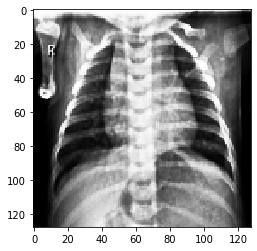

In [ ]:
plt.imshow((X_train[1]).reshape(128,128),interpolation = 'None', cmap = 'gray')

In [ ]:
X_train.shape

(1892, 128, 128)

In [ ]:
#plot performance
def plot_model_performance(metric, validations_metric, history):
    plt.plot(history.history[validations_metric],label = str('Validation ' + metric))
    plt.legend()

In [ ]:
batch_size = 256
num_classes = 3
epochs = 25

In [ ]:
img_rows,img_cols = 128,128

In [ ]:
def MODEL(CONV1, CONV2, DENSE, KERNEL_CONV, KERNEL_POOL, ACTIVATION, DROPOUT, OPTIMIZER):

    model = Sequential()
    model.add(Conv2D(CONV1, kernel_size=(KERNEL_CONV, KERNEL_CONV),
                 activation=ACTIVATION,
                 input_shape=(img_rows,img_cols,1)))
    model.add(MaxPooling2D((KERNEL_POOL, KERNEL_POOL)))
    model.add(Conv2D(CONV2, (KERNEL_CONV, KERNEL_CONV), activation='relu'))
    model.add(Flatten())
    model.add(Dense(DENSE, activation=ACTIVATION))
    model.add(Dropout(DROPOUT))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer = OPTIMIZER, metrics = ['accuracy'])

    return model

### Analysis with Optimizer

In [ ]:
model_adam = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_sgd = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='sgd')
model_rmsprop = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='rmsprop')
model_adagrad = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adagrad')
model_adadelta = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adadelta')

In [ ]:
history_adam = model_adam.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 703ms/step - loss: 1545.3812 - accuracy: 0.6250 - val_loss: 76.6651 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 446ms/step - loss: 15.0066 - accuracy: 0.7114 - val_loss: 1.0746 - val_accuracy: 0.6796
Epoch 3/25
7/7 [==============================] - 3s 468ms/step - loss: 0.3252 - accuracy: 0.9080 - val_loss: 0.3060 - val_accuracy: 0.9085
Epoch 4/25
7/7 [==============================] - 3s 445ms/step - loss: 0.0822 - accuracy: 0.9708 - val_loss: 0.3410 - val_accuracy: 0.9155
Epoch 5/25
7/7 [==============================] - 3s 446ms/step - loss: 0.0235 - accuracy: 0.9938 - val_loss: 0.4682 - val_accuracy: 0.9085
Epoch 6/25
7/7 [==============================] - 3s 450ms/step - loss: 0.0416 - accuracy: 0.9932 - val_loss: 0.6502 - val_accuracy: 0.9225
Epoch 7/25
7/7 [==============================] - 3s 447ms/step - loss: 1.9789 - accuracy: 0.9017 - val_loss: 1.3144 - val_accuracy: 0.8732
Epoch 8/25
7/7 

In [ ]:
history_sgd = model_sgd.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 465ms/step - loss: nan - accuracy: 0.4521 - val_loss: nan - val_accuracy: 0.1479
Epoch 2/25
7/7 [==============================] - 3s 418ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 3/25
7/7 [==============================] - 3s 419ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 4/25
7/7 [==============================] - 3s 417ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 5/25
7/7 [==============================] - 3s 418ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 6/25
7/7 [==============================] - 3s 420ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 7/25
7/7 [==============================] - 3s 420ms/step - loss: nan - accuracy: 0.1219 - val_loss: nan - val_accuracy: 0.1479
Epoch 8/25
7/7 [==============================] - 3s 418ms/ste

In [ ]:
history_rmsprop = model_rmsprop.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 559ms/step - loss: 7223.0220 - accuracy: 0.4658 - val_loss: 63.6491 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 489ms/step - loss: 71.1378 - accuracy: 0.6256 - val_loss: 57.7529 - val_accuracy: 0.2289
Epoch 3/25
7/7 [==============================] - 3s 494ms/step - loss: 24.9050 - accuracy: 0.6810 - val_loss: 1.1174 - val_accuracy: 0.8873
Epoch 4/25
7/7 [==============================] - 3s 491ms/step - loss: 8.3665 - accuracy: 0.7090 - val_loss: 0.6712 - val_accuracy: 0.8768
Epoch 5/25
7/7 [==============================] - 4s 495ms/step - loss: 6.7078 - accuracy: 0.6971 - val_loss: 0.8100 - val_accuracy: 0.8944
Epoch 6/25
7/7 [==============================] - 4s 495ms/step - loss: 44.3679 - accuracy: 0.6001 - val_loss: 3.4376 - val_accuracy: 0.8239
Epoch 7/25
7/7 [==============================] - 4s 495ms/step - loss: 3.8529 - accuracy: 0.7786 - val_loss: 195.6023 - val_accuracy: 0.2042
Epoch 8/25

In [ ]:
history_adagrad = model_adagrad.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 504ms/step - loss: 622.8217 - accuracy: 0.5572 - val_loss: 32.1832 - val_accuracy: 0.8380
Epoch 2/25
7/7 [==============================] - 3s 439ms/step - loss: 44.6998 - accuracy: 0.7034 - val_loss: 2.7658 - val_accuracy: 0.8873
Epoch 3/25
7/7 [==============================] - 3s 440ms/step - loss: 17.2437 - accuracy: 0.7743 - val_loss: 6.9781 - val_accuracy: 0.8380
Epoch 4/25
7/7 [==============================] - 3s 440ms/step - loss: 9.8094 - accuracy: 0.8228 - val_loss: 1.3092 - val_accuracy: 0.9261
Epoch 5/25
7/7 [==============================] - 3s 440ms/step - loss: 6.6628 - accuracy: 0.8340 - val_loss: 1.8878 - val_accuracy: 0.9296
Epoch 6/25
7/7 [==============================] - 3s 442ms/step - loss: 4.1594 - accuracy: 0.8607 - val_loss: 10.0740 - val_accuracy: 0.8345
Epoch 7/25
7/7 [==============================] - 3s 443ms/step - loss: 3.8669 - accuracy: 0.8837 - val_loss: 1.2795 - val_accuracy: 0.9366
Epoch 8/25
7/7

In [ ]:
history_adadelta = model_adadelta.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 507ms/step - loss: 4.0554 - accuracy: 0.6281 - val_loss: 1.8439 - val_accuracy: 0.8063
Epoch 2/25
7/7 [==============================] - 3s 475ms/step - loss: 2.4453 - accuracy: 0.7432 - val_loss: 1.2257 - val_accuracy: 0.6620
Epoch 3/25
7/7 [==============================] - 3s 451ms/step - loss: 1.9007 - accuracy: 0.7711 - val_loss: 0.8889 - val_accuracy: 0.8380
Epoch 4/25
7/7 [==============================] - 3s 452ms/step - loss: 0.9462 - accuracy: 0.8190 - val_loss: 0.5757 - val_accuracy: 0.8627
Epoch 5/25
7/7 [==============================] - 3s 453ms/step - loss: 0.8851 - accuracy: 0.8408 - val_loss: 1.3974 - val_accuracy: 0.8415
Epoch 6/25
7/7 [==============================] - 3s 476ms/step - loss: 0.9754 - accuracy: 0.8327 - val_loss: 0.5534 - val_accuracy: 0.8592
Epoch 7/25
7/7 [==============================] - 3s 452ms/step - loss: 1.0343 - accuracy: 0.8116 - val_loss: 1.3833 - val_accuracy: 0.8415
Epoch 8/25
7/7 [====

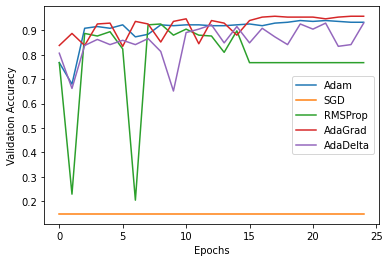

In [ ]:
#plot_model_performance('accuracy', 'val_accuracy', history_adam)
#plot_model_performance('accuracy', 'val_accuracy', history_sgd)
#plot_model_performance('accuracy', 'val_accuracy', history_rmsprop)
#plot_model_performance('accuracy', 'val_accuracy', history_adagrad)
#plot_model_performance('accuracy', 'val_accuracy', history_adadelta)

plt.plot(history_adam.history['val_accuracy'],label = str('Adam'))
plt.plot(history_sgd.history['val_accuracy'],label = str('SGD'))
plt.plot(history_rmsprop.history['val_accuracy'],label = str('RMSProp'))
plt.plot(history_adagrad.history['val_accuracy'],label = str('AdaGrad'))
plt.plot(history_adadelta.history['val_accuracy'],label = str('AdaDelta'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

### Analysis with Dropout

In [ ]:
model_10 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_20 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.2, OPTIMIZER='adam')
model_30 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.3, OPTIMIZER='adam')
model_40 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.4, OPTIMIZER='adam')
model_50 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.5, OPTIMIZER='adam')

In [ ]:
history_10 = model_10.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 535ms/step - loss: 1017.5148 - accuracy: 0.6331 - val_loss: 238.8029 - val_accuracy: 0.1479
Epoch 2/25
7/7 [==============================] - 3s 495ms/step - loss: 46.8526 - accuracy: 0.6262 - val_loss: 0.7183 - val_accuracy: 0.7042
Epoch 3/25
7/7 [==============================] - 3s 489ms/step - loss: 0.4668 - accuracy: 0.8464 - val_loss: 0.4305 - val_accuracy: 0.8451
Epoch 4/25
7/7 [==============================] - 3s 493ms/step - loss: 0.1749 - accuracy: 0.9422 - val_loss: 0.4992 - val_accuracy: 0.8873
Epoch 5/25
7/7 [==============================] - 4s 516ms/step - loss: 0.0345 - accuracy: 0.9888 - val_loss: 0.3250 - val_accuracy: 0.9155
Epoch 6/25
7/7 [==============================] - 3s 493ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.3583 - val_accuracy: 0.9401
Epoch 7/25
7/7 [==============================] - 3s 495ms/step - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.4019 - val_accuracy: 0.9261
Epoch 8/25
7/7

In [ ]:
history_20 = model_20.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 56s 500ms/step - loss: 1509.5990 - accuracy: 0.6530 - val_loss: 17.7426 - val_accuracy: 0.8275
Epoch 2/25
7/7 [==============================] - 3s 436ms/step - loss: 5.8302 - accuracy: 0.4384 - val_loss: 0.9373 - val_accuracy: 0.6514
Epoch 3/25
7/7 [==============================] - 3s 436ms/step - loss: 0.7562 - accuracy: 0.7898 - val_loss: 0.3695 - val_accuracy: 0.8873
Epoch 4/25
7/7 [==============================] - 3s 437ms/step - loss: 0.2627 - accuracy: 0.9142 - val_loss: 0.2644 - val_accuracy: 0.8979
Epoch 5/25
7/7 [==============================] - 3s 438ms/step - loss: 0.1052 - accuracy: 0.9608 - val_loss: 0.1919 - val_accuracy: 0.9366
Epoch 6/25
7/7 [==============================] - 3s 437ms/step - loss: 0.0251 - accuracy: 0.9894 - val_loss: 0.2548 - val_accuracy: 0.9366
Epoch 7/25
7/7 [==============================] - 3s 438ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.3254 - val_accuracy: 0.9472
Epoch 8/25
7/7 

In [ ]:
history_30 = model_30.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 488ms/step - loss: 1572.1858 - accuracy: 0.5628 - val_loss: 32.2978 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 442ms/step - loss: 13.9698 - accuracy: 0.5746 - val_loss: 0.6428 - val_accuracy: 0.7852
Epoch 3/25
7/7 [==============================] - 3s 440ms/step - loss: 0.3833 - accuracy: 0.8794 - val_loss: 0.3527 - val_accuracy: 0.8803
Epoch 4/25
7/7 [==============================] - 3s 441ms/step - loss: 0.1784 - accuracy: 0.9471 - val_loss: 0.2520 - val_accuracy: 0.9049
Epoch 5/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0686 - accuracy: 0.9782 - val_loss: 0.2857 - val_accuracy: 0.9120
Epoch 6/25
7/7 [==============================] - 3s 440ms/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.3343 - val_accuracy: 0.9225
Epoch 7/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 0.3667 - val_accuracy: 0.9014
Epoch 8/25
7/7 

In [ ]:
history_40 = model_40.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 560ms/step - loss: 887.2134 - accuracy: 0.6250 - val_loss: 4.9246 - val_accuracy: 0.2782
Epoch 2/25
7/7 [==============================] - 4s 512ms/step - loss: 2.5839 - accuracy: 0.5541 - val_loss: 0.6090 - val_accuracy: 0.8204
Epoch 3/25
7/7 [==============================] - 3s 488ms/step - loss: 0.3653 - accuracy: 0.8955 - val_loss: 0.5177 - val_accuracy: 0.8838
Epoch 4/25
7/7 [==============================] - 3s 492ms/step - loss: 0.1362 - accuracy: 0.9534 - val_loss: 0.3467 - val_accuracy: 0.9014
Epoch 5/25
7/7 [==============================] - 3s 490ms/step - loss: 0.0783 - accuracy: 0.9820 - val_loss: 0.4885 - val_accuracy: 0.9190
Epoch 6/25
7/7 [==============================] - 3s 491ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.6737 - val_accuracy: 0.9261
Epoch 7/25
7/7 [==============================] - 3s 494ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.7059 - val_accuracy: 0.9261
Epoch 8/25
7/7 [==

In [ ]:
history_50 = model_50.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 525ms/step - loss: 779.9426 - accuracy: 0.6760 - val_loss: 6.3504 - val_accuracy: 0.2254
Epoch 2/25
7/7 [==============================] - 3s 489ms/step - loss: 3.2741 - accuracy: 0.4502 - val_loss: 0.6273 - val_accuracy: 0.8099
Epoch 3/25
7/7 [==============================] - 3s 485ms/step - loss: 0.3300 - accuracy: 0.8881 - val_loss: 0.5330 - val_accuracy: 0.9120
Epoch 4/25
7/7 [==============================] - 3s 484ms/step - loss: 0.1325 - accuracy: 0.9577 - val_loss: 0.3119 - val_accuracy: 0.9155
Epoch 5/25
7/7 [==============================] - 3s 487ms/step - loss: 0.0843 - accuracy: 0.9745 - val_loss: 0.2483 - val_accuracy: 0.9261
Epoch 6/25
7/7 [==============================] - 3s 490ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.3206 - val_accuracy: 0.9401
Epoch 7/25
7/7 [==============================] - 3s 488ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.5253 - val_accuracy: 0.9085
Epoch 8/25
7/7 [==

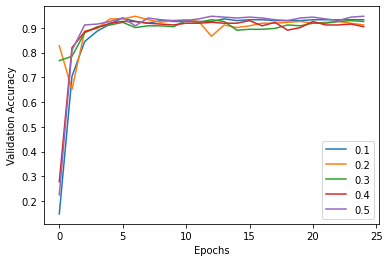

In [ ]:
plt.plot(history_10.history['val_accuracy'],label = str('0.1'))
plt.plot(history_20.history['val_accuracy'],label = str('0.2'))
plt.plot(history_30.history['val_accuracy'],label = str('0.3'))
plt.plot(history_40.history['val_accuracy'],label = str('0.4'))
plt.plot(history_50.history['val_accuracy'],label = str('0.5'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

### Analysis with Activation Function

In [ ]:
model_relu = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_tanh = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='tanh', DROPOUT = 0.1, OPTIMIZER='adam')
model_sigmoid = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='sigmoid', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_relu = model_relu.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 10s 726ms/step - loss: 1107.7588 - accuracy: 0.5106 - val_loss: 31.7900 - val_accuracy: 0.7923
Epoch 2/25
7/7 [==============================] - 3s 438ms/step - loss: 7.1984 - accuracy: 0.7413 - val_loss: 0.4399 - val_accuracy: 0.8768
Epoch 3/25
7/7 [==============================] - 3s 460ms/step - loss: 0.2748 - accuracy: 0.9235 - val_loss: 0.2909 - val_accuracy: 0.9155
Epoch 4/25
7/7 [==============================] - 3s 438ms/step - loss: 0.0979 - accuracy: 0.9614 - val_loss: 0.2319 - val_accuracy: 0.9014
Epoch 5/25
7/7 [==============================] - 3s 438ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.2305 - val_accuracy: 0.9331
Epoch 6/25
7/7 [==============================] - 3s 438ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.3502 - val_accuracy: 0.9437
Epoch 7/25
7/7 [==============================] - 3s 438ms/step - loss: 0.0192 - accuracy: 0.9919 - val_loss: 0.2594 - val_accuracy: 0.9437
Epoch 8/25
7/7 

In [ ]:
history_tanh = model_tanh.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 466ms/step - loss: 2.7459 - accuracy: 0.7108 - val_loss: 2.8008 - val_accuracy: 0.7923
Epoch 2/25
7/7 [==============================] - 3s 432ms/step - loss: 2.7894 - accuracy: 0.7886 - val_loss: 2.4519 - val_accuracy: 0.7923
Epoch 3/25
7/7 [==============================] - 3s 429ms/step - loss: 2.4189 - accuracy: 0.7886 - val_loss: 2.0928 - val_accuracy: 0.7923
Epoch 4/25
7/7 [==============================] - 3s 434ms/step - loss: 2.0580 - accuracy: 0.7886 - val_loss: 1.7271 - val_accuracy: 0.7923
Epoch 5/25
7/7 [==============================] - 3s 431ms/step - loss: 1.6642 - accuracy: 0.7886 - val_loss: 1.3704 - val_accuracy: 0.7923
Epoch 6/25
7/7 [==============================] - 3s 432ms/step - loss: 1.3381 - accuracy: 0.7886 - val_loss: 1.0349 - val_accuracy: 0.7923
Epoch 7/25
7/7 [==============================] - 3s 432ms/step - loss: 1.0210 - accuracy: 0.7886 - val_loss: 0.8097 - val_accuracy: 0.7923
Epoch 8/25
7/7 [====

In [ ]:
history_sigmoid = model_sigmoid.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 3s 448ms/step - loss: 0.6726 - accuracy: 0.7886 - val_loss: 0.6468 - val_accuracy: 0.7923
Epoch 2/25
7/7 [==============================] - 3s 437ms/step - loss: 0.6651 - accuracy: 0.7886 - val_loss: 0.6463 - val_accuracy: 0.7923
Epoch 3/25
7/7 [==============================] - 3s 439ms/step - loss: 0.6724 - accuracy: 0.7886 - val_loss: 0.6467 - val_accuracy: 0.7923
Epoch 4/25
7/7 [==============================] - 3s 438ms/step - loss: 0.6745 - accuracy: 0.7886 - val_loss: 0.6469 - val_accuracy: 0.7923
Epoch 5/25
7/7 [==============================] - 3s 440ms/step - loss: 0.6784 - accuracy: 0.7886 - val_loss: 0.6459 - val_accuracy: 0.7923
Epoch 6/25
7/7 [==============================] - 3s 437ms/step - loss: 0.6765 - accuracy: 0.7886 - val_loss: 0.6450 - val_accuracy: 0.7923
Epoch 7/25
7/7 [==============================] - 3s 438ms/step - loss: 0.6720 - accuracy: 0.7886 - val_loss: 0.6448 - val_accuracy: 0.7923
Epoch 8/25
7/7 [====

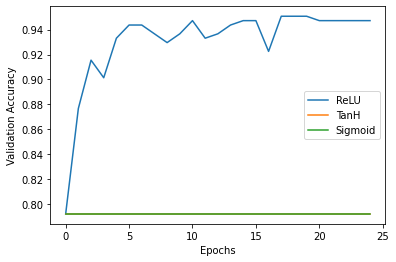

In [ ]:
plt.plot(history_relu.history['val_accuracy'],label = str('ReLU'))
plt.plot(history_tanh.history['val_accuracy'],label = str('TanH'))
plt.plot(history_sigmoid.history['val_accuracy'],label = str('Sigmoid'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();

### Analysis with MaxPool Kernel Size

In [ ]:
model_pool2 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_pool3 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=3, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_pool4 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=4, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_pool2 = model_pool2.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 479ms/step - loss: 722.9271 - accuracy: 0.6922 - val_loss: 7.0079 - val_accuracy: 0.8345
Epoch 2/25
7/7 [==============================] - 3s 442ms/step - loss: 6.1067 - accuracy: 0.7948 - val_loss: 0.8112 - val_accuracy: 0.8521
Epoch 3/25
7/7 [==============================] - 3s 441ms/step - loss: 0.3367 - accuracy: 0.9111 - val_loss: 0.2458 - val_accuracy: 0.9049
Epoch 4/25
7/7 [==============================] - 3s 462ms/step - loss: 0.1137 - accuracy: 0.9602 - val_loss: 0.1946 - val_accuracy: 0.9261
Epoch 5/25
7/7 [==============================] - 3s 439ms/step - loss: 0.0341 - accuracy: 0.9894 - val_loss: 0.2214 - val_accuracy: 0.9296
Epoch 6/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.2187 - val_accuracy: 0.9366
Epoch 7/25
7/7 [==============================] - 3s 440ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3083 - val_accuracy: 0.9296
Epoch 8/25
7/7 [==

In [ ]:
history_pool3 = model_pool3.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 381ms/step - loss: 405.1625 - accuracy: 0.5933 - val_loss: 5.8148 - val_accuracy: 0.7993
Epoch 2/25
7/7 [==============================] - 2s 259ms/step - loss: 2.1810 - accuracy: 0.5864 - val_loss: 0.7905 - val_accuracy: 0.8169
Epoch 3/25
7/7 [==============================] - 2s 259ms/step - loss: 0.3744 - accuracy: 0.8918 - val_loss: 0.2888 - val_accuracy: 0.9014
Epoch 4/25
7/7 [==============================] - 2s 259ms/step - loss: 0.1922 - accuracy: 0.9422 - val_loss: 0.2241 - val_accuracy: 0.9366
Epoch 5/25
7/7 [==============================] - 2s 257ms/step - loss: 0.0711 - accuracy: 0.9807 - val_loss: 0.2514 - val_accuracy: 0.9401
Epoch 6/25
7/7 [==============================] - 2s 259ms/step - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.3444 - val_accuracy: 0.9331
Epoch 7/25
7/7 [==============================] - 2s 258ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.2839 - val_accuracy: 0.9296
Epoch 8/25
7/7 [==

In [ ]:
history_pool4 = model_pool4.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 3s 281ms/step - loss: 316.2343 - accuracy: 0.6573 - val_loss: 6.0257 - val_accuracy: 0.4120
Epoch 2/25
7/7 [==============================] - 1s 202ms/step - loss: 1.7401 - accuracy: 0.6816 - val_loss: 0.5784 - val_accuracy: 0.8063
Epoch 3/25
7/7 [==============================] - 1s 209ms/step - loss: 0.4610 - accuracy: 0.8383 - val_loss: 0.4291 - val_accuracy: 0.8345
Epoch 4/25
7/7 [==============================] - 1s 205ms/step - loss: 0.2257 - accuracy: 0.9235 - val_loss: 0.2668 - val_accuracy: 0.9366
Epoch 5/25
7/7 [==============================] - 1s 200ms/step - loss: 0.2250 - accuracy: 0.9409 - val_loss: 0.1839 - val_accuracy: 0.9261
Epoch 6/25
7/7 [==============================] - 1s 203ms/step - loss: 0.0973 - accuracy: 0.9664 - val_loss: 0.1936 - val_accuracy: 0.9401
Epoch 7/25
7/7 [==============================] - 1s 201ms/step - loss: 0.0588 - accuracy: 0.9770 - val_loss: 0.1765 - val_accuracy: 0.9401
Epoch 8/25
7/7 [==

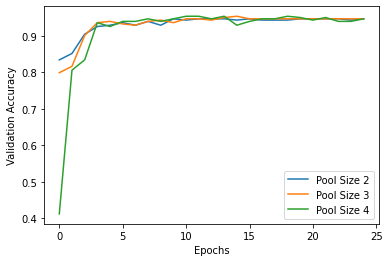

In [ ]:
plt.plot(history_pool2.history['val_accuracy'],label = str('Pool Size 2'))
plt.plot(history_pool3.history['val_accuracy'],label = str('Pool Size 3'))
plt.plot(history_pool4.history['val_accuracy'],label = str('Pool Size 4'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();

### Analysis with Convolution Kernel Size

In [ ]:
model_conv3 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_conv5 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=5, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_conv7 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=7, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_conv3 = model_conv3.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 12s 688ms/step - loss: 1018.0477 - accuracy: 0.6573 - val_loss: 89.1403 - val_accuracy: 0.7711
Epoch 2/25
7/7 [==============================] - 3s 437ms/step - loss: 17.6731 - accuracy: 0.5821 - val_loss: 0.7780 - val_accuracy: 0.8099
Epoch 3/25
7/7 [==============================] - 3s 438ms/step - loss: 0.4271 - accuracy: 0.8787 - val_loss: 0.3475 - val_accuracy: 0.8979
Epoch 4/25
7/7 [==============================] - 3s 437ms/step - loss: 0.1596 - accuracy: 0.9471 - val_loss: 0.2992 - val_accuracy: 0.9437
Epoch 5/25
7/7 [==============================] - 3s 439ms/step - loss: 0.0671 - accuracy: 0.9770 - val_loss: 0.3003 - val_accuracy: 0.9472
Epoch 6/25
7/7 [==============================] - 3s 440ms/step - loss: 0.0243 - accuracy: 0.9938 - val_loss: 0.3502 - val_accuracy: 0.9507
Epoch 7/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0128 - accuracy: 0.9950 - val_loss: 0.3817 - val_accuracy: 0.9472
Epoch 8/25
7/7

In [ ]:
history_conv5 = model_conv5.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 13s 906ms/step - loss: 548.5521 - accuracy: 0.5292 - val_loss: 0.9802 - val_accuracy: 0.5035
Epoch 2/25
7/7 [==============================] - 3s 441ms/step - loss: 1.1154 - accuracy: 0.7693 - val_loss: 0.9157 - val_accuracy: 0.8028
Epoch 3/25
7/7 [==============================] - 3s 442ms/step - loss: 0.8605 - accuracy: 0.8066 - val_loss: 0.8621 - val_accuracy: 0.7641
Epoch 4/25
7/7 [==============================] - 3s 443ms/step - loss: 0.6567 - accuracy: 0.8159 - val_loss: 11.1951 - val_accuracy: 0.7641
Epoch 5/25
7/7 [==============================] - 3s 441ms/step - loss: 1.9966 - accuracy: 0.8022 - val_loss: 0.5765 - val_accuracy: 0.7782
Epoch 6/25
7/7 [==============================] - 3s 441ms/step - loss: 0.4375 - accuracy: 0.8570 - val_loss: 0.4898 - val_accuracy: 0.8204
Epoch 7/25
7/7 [==============================] - 3s 442ms/step - loss: 0.3162 - accuracy: 0.8881 - val_loss: 0.4069 - val_accuracy: 0.8873
Epoch 8/25
7/7 [

In [ ]:
history_conv7 = model_conv7.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 18s 1s/step - loss: 884.6604 - accuracy: 0.5939 - val_loss: 1.0641 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 427ms/step - loss: 4.7806 - accuracy: 0.7923 - val_loss: 1.0221 - val_accuracy: 0.7711
Epoch 3/25
7/7 [==============================] - 3s 448ms/step - loss: 0.7998 - accuracy: 0.7581 - val_loss: 0.6078 - val_accuracy: 0.7711
Epoch 4/25
7/7 [==============================] - 3s 426ms/step - loss: 0.6139 - accuracy: 0.8047 - val_loss: 0.6488 - val_accuracy: 0.7958
Epoch 5/25
7/7 [==============================] - 3s 427ms/step - loss: 0.5129 - accuracy: 0.8514 - val_loss: 0.4417 - val_accuracy: 0.8803
Epoch 6/25
7/7 [==============================] - 3s 429ms/step - loss: 0.6197 - accuracy: 0.8078 - val_loss: 0.5664 - val_accuracy: 0.8169
Epoch 7/25
7/7 [==============================] - 3s 428ms/step - loss: 0.3543 - accuracy: 0.9005 - val_loss: 0.4677 - val_accuracy: 0.8732
Epoch 8/25
7/7 [====

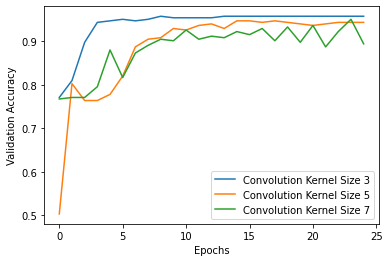

In [ ]:
plt.plot(history_conv3.history['val_accuracy'],label = str('Convolution Kernel Size 3'))
plt.plot(history_conv5.history['val_accuracy'],label = str('Convolution Kernel Size 5'))
plt.plot(history_conv7.history['val_accuracy'],label = str('Convolution Kernel Size 7'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();

### Analysis with Dense Layer Size

In [ ]:
model_dense32 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 32, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_dense64 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 64, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_dense128 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_dense256 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 256, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_dense32 = model_dense32.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 435ms/step - loss: 535.2494 - accuracy: 0.6536 - val_loss: 100.3091 - val_accuracy: 0.1338
Epoch 2/25
7/7 [==============================] - 3s 376ms/step - loss: 19.4846 - accuracy: 0.6095 - val_loss: 0.4764 - val_accuracy: 0.8627
Epoch 3/25
7/7 [==============================] - 3s 375ms/step - loss: 0.2808 - accuracy: 0.9142 - val_loss: 0.3931 - val_accuracy: 0.9049
Epoch 4/25
7/7 [==============================] - 3s 373ms/step - loss: 0.1236 - accuracy: 0.9577 - val_loss: 0.2293 - val_accuracy: 0.9225
Epoch 5/25
7/7 [==============================] - 3s 375ms/step - loss: 0.0670 - accuracy: 0.9770 - val_loss: 0.3350 - val_accuracy: 0.9225
Epoch 6/25
7/7 [==============================] - 3s 374ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.3540 - val_accuracy: 0.9437
Epoch 7/25
7/7 [==============================] - 3s 374ms/step - loss: 0.0273 - accuracy: 0.9925 - val_loss: 0.3057 - val_accuracy: 0.9401
Epoch 8/25
7/7 

In [ ]:
history_dense64 = model_dense64.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 444ms/step - loss: 907.2097 - accuracy: 0.5939 - val_loss: 1.8089 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 390ms/step - loss: 0.8316 - accuracy: 0.7973 - val_loss: 0.3968 - val_accuracy: 0.8873
Epoch 3/25
7/7 [==============================] - 3s 419ms/step - loss: 0.1737 - accuracy: 0.9453 - val_loss: 0.3629 - val_accuracy: 0.9401
Epoch 4/25
7/7 [==============================] - 3s 392ms/step - loss: 0.0776 - accuracy: 0.9720 - val_loss: 0.2468 - val_accuracy: 0.9507
Epoch 5/25
7/7 [==============================] - 3s 392ms/step - loss: 0.0235 - accuracy: 0.9932 - val_loss: 0.3597 - val_accuracy: 0.9472
Epoch 6/25
7/7 [==============================] - 3s 418ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.3738 - val_accuracy: 0.9542
Epoch 7/25
7/7 [==============================] - 3s 392ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.9613
Epoch 8/25
7/7 [==

In [ ]:
history_dense128 = model_dense128.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 4s 472ms/step - loss: 1191.4937 - accuracy: 0.5516 - val_loss: 30.6274 - val_accuracy: 0.7676
Epoch 2/25
7/7 [==============================] - 3s 441ms/step - loss: 6.9741 - accuracy: 0.7506 - val_loss: 0.4267 - val_accuracy: 0.8521
Epoch 3/25
7/7 [==============================] - 3s 439ms/step - loss: 0.2097 - accuracy: 0.9241 - val_loss: 0.2557 - val_accuracy: 0.9225
Epoch 4/25
7/7 [==============================] - 3s 442ms/step - loss: 0.0621 - accuracy: 0.9813 - val_loss: 0.2526 - val_accuracy: 0.9296
Epoch 5/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0322 - accuracy: 0.9913 - val_loss: 0.2368 - val_accuracy: 0.9507
Epoch 6/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0078 - accuracy: 0.9994 - val_loss: 0.2703 - val_accuracy: 0.9542
Epoch 7/25
7/7 [==============================] - 3s 441ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2396 - val_accuracy: 0.9542
Epoch 8/25
7/7 [

In [ ]:
history_dense256 = model_dense256.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 5s 541ms/step - loss: 1614.4536 - accuracy: 0.6586 - val_loss: 36.0077 - val_accuracy: 0.7254
Epoch 2/25
7/7 [==============================] - 4s 503ms/step - loss: 11.1091 - accuracy: 0.6474 - val_loss: 3.3514 - val_accuracy: 0.7676
Epoch 3/25
7/7 [==============================] - 4s 517ms/step - loss: 0.9606 - accuracy: 0.8458 - val_loss: 0.4067 - val_accuracy: 0.8803
Epoch 4/25
7/7 [==============================] - 4s 502ms/step - loss: 0.2531 - accuracy: 0.9136 - val_loss: 0.2720 - val_accuracy: 0.9049
Epoch 5/25
7/7 [==============================] - 4s 503ms/step - loss: 0.0844 - accuracy: 0.9751 - val_loss: 0.2322 - val_accuracy: 0.9401
Epoch 6/25
7/7 [==============================] - 4s 500ms/step - loss: 0.0603 - accuracy: 0.9851 - val_loss: 0.4199 - val_accuracy: 0.9190
Epoch 7/25
7/7 [==============================] - 4s 518ms/step - loss: 0.0357 - accuracy: 0.9894 - val_loss: 0.3667 - val_accuracy: 0.9296
Epoch 8/25
7/7 

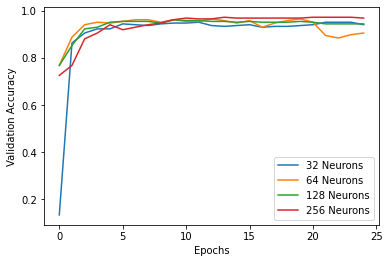

In [ ]:
plt.plot(history_dense32.history['val_accuracy'],label = str('32 Neurons'))
plt.plot(history_dense64.history['val_accuracy'],label = str('64 Neurons'))
plt.plot(history_dense128.history['val_accuracy'],label = str('128 Neurons'))
plt.plot(history_dense256.history['val_accuracy'],label = str('256 Neurons'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();

### Analysis with 2nd Convolution Layer Size

In [ ]:
model_CONV_2_32 = MODEL(CONV1 = 64, CONV2 = 32, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_CONV_2_64 = MODEL(CONV1 = 64, CONV2 = 64, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_CONV_2_128 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_CONV_2_256 = MODEL(CONV1 = 64, CONV2 = 256, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_CONV_2_32 = model_CONV_2_32.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 6s 373ms/step - loss: 674.7263 - accuracy: 0.6517 - val_loss: 17.2205 - val_accuracy: 0.8099
Epoch 2/25
7/7 [==============================] - 2s 241ms/step - loss: 5.0057 - accuracy: 0.4447 - val_loss: 0.9478 - val_accuracy: 0.8099
Epoch 3/25
7/7 [==============================] - 2s 243ms/step - loss: 0.7983 - accuracy: 0.8091 - val_loss: 0.7599 - val_accuracy: 0.8275
Epoch 4/25
7/7 [==============================] - 2s 243ms/step - loss: 0.5768 - accuracy: 0.8669 - val_loss: 0.5646 - val_accuracy: 0.8239
Epoch 5/25
7/7 [==============================] - 2s 244ms/step - loss: 0.3327 - accuracy: 0.8968 - val_loss: 0.3613 - val_accuracy: 0.8873
Epoch 6/25
7/7 [==============================] - 2s 242ms/step - loss: 0.1845 - accuracy: 0.9459 - val_loss: 0.2686 - val_accuracy: 0.9225
Epoch 7/25
7/7 [==============================] - 2s 242ms/step - loss: 0.0777 - accuracy: 0.9720 - val_loss: 0.2528 - val_accuracy: 0.9120
Epoch 8/25
7/7 [=

In [ ]:
history_CONV_2_64 = model_CONV_2_64.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 6s 448ms/step - loss: 847.7795 - accuracy: 0.5951 - val_loss: 4.3793 - val_accuracy: 0.7993
Epoch 2/25
7/7 [==============================] - 2s 295ms/step - loss: 2.0761 - accuracy: 0.4459 - val_loss: 0.4990 - val_accuracy: 0.8556
Epoch 3/25
7/7 [==============================] - 2s 300ms/step - loss: 0.9394 - accuracy: 0.8308 - val_loss: 0.5320 - val_accuracy: 0.8521
Epoch 4/25
7/7 [==============================] - 2s 299ms/step - loss: 0.3343 - accuracy: 0.8955 - val_loss: 0.2928 - val_accuracy: 0.9155
Epoch 5/25
7/7 [==============================] - 2s 299ms/step - loss: 0.1303 - accuracy: 0.9471 - val_loss: 0.2426 - val_accuracy: 0.9225
Epoch 6/25
7/7 [==============================] - 2s 299ms/step - loss: 0.0524 - accuracy: 0.9801 - val_loss: 0.3327 - val_accuracy: 0.9049
Epoch 7/25
7/7 [==============================] - 2s 298ms/step - loss: 0.0254 - accuracy: 0.9894 - val_loss: 0.2732 - val_accuracy: 0.9401
Epoch 8/25
7/7 [==

In [ ]:
history_CONV_2_128 = model_CONV_2_128.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 8s 703ms/step - loss: 1290.0912 - accuracy: 0.6007 - val_loss: 9.6776 - val_accuracy: 0.8099
Epoch 2/25
7/7 [==============================] - 3s 443ms/step - loss: 2.3043 - accuracy: 0.6803 - val_loss: 0.5130 - val_accuracy: 0.8521
Epoch 3/25
7/7 [==============================] - 3s 445ms/step - loss: 1.5236 - accuracy: 0.8545 - val_loss: 0.4850 - val_accuracy: 0.8134
Epoch 4/25
7/7 [==============================] - 3s 442ms/step - loss: 0.2082 - accuracy: 0.9204 - val_loss: 0.2677 - val_accuracy: 0.9225
Epoch 5/25
7/7 [==============================] - 3s 443ms/step - loss: 0.0588 - accuracy: 0.9820 - val_loss: 0.3421 - val_accuracy: 0.9296
Epoch 6/25
7/7 [==============================] - 3s 444ms/step - loss: 0.0211 - accuracy: 0.9950 - val_loss: 0.4310 - val_accuracy: 0.9401
Epoch 7/25
7/7 [==============================] - 3s 443ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.5917 - val_accuracy: 0.9507
Epoch 8/25
7/7 [=

In [ ]:
history_CONV_2_256 = model_CONV_2_256.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 14s 1s/step - loss: 991.4435 - accuracy: 0.6082 - val_loss: 3.3376 - val_accuracy: 0.7148
Epoch 2/25
7/7 [==============================] - 6s 807ms/step - loss: 1.2864 - accuracy: 0.7394 - val_loss: 0.2675 - val_accuracy: 0.8979
Epoch 3/25
7/7 [==============================] - 6s 809ms/step - loss: 0.1866 - accuracy: 0.9229 - val_loss: 0.2550 - val_accuracy: 0.9014
Epoch 4/25
7/7 [==============================] - 6s 807ms/step - loss: 0.1010 - accuracy: 0.9639 - val_loss: 0.2262 - val_accuracy: 0.9366
Epoch 5/25
7/7 [==============================] - 6s 810ms/step - loss: 0.0913 - accuracy: 0.9621 - val_loss: 0.2890 - val_accuracy: 0.9437
Epoch 6/25
7/7 [==============================] - 6s 807ms/step - loss: 0.0283 - accuracy: 0.9888 - val_loss: 0.2661 - val_accuracy: 0.9507
Epoch 7/25
7/7 [==============================] - 6s 808ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.3368 - val_accuracy: 0.9437
Epoch 8/25
7/7 [====

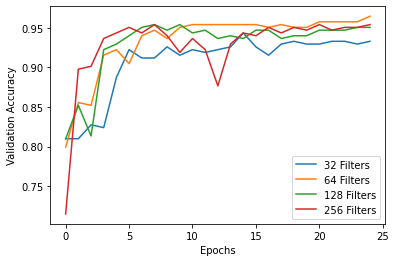

In [ ]:
plt.plot(history_CONV_2_32.history['val_accuracy'],label = str('32 Filters'))
plt.plot(history_CONV_2_64.history['val_accuracy'],label = str('64 Filters'))
plt.plot(history_CONV_2_128.history['val_accuracy'],label = str('128 Filters'))
plt.plot(history_CONV_2_256.history['val_accuracy'],label = str('256 Filters'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();

### Analysis with 1st Convolution Layer Size

In [ ]:
model_CONV_1_32 = MODEL(CONV1 = 32, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_CONV_1_64 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')
model_CONV_1_128 = MODEL(CONV1 = 128, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
history_CONV_1_32 = model_CONV_1_32.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 10s 518ms/step - loss: 2454.7205 - accuracy: 0.5939 - val_loss: 600.0208 - val_accuracy: 0.7711
Epoch 2/25
7/7 [==============================] - 2s 338ms/step - loss: 159.0437 - accuracy: 0.7631 - val_loss: 0.7337 - val_accuracy: 0.7606
Epoch 3/25
7/7 [==============================] - 3s 359ms/step - loss: 0.5059 - accuracy: 0.8445 - val_loss: 0.1632 - val_accuracy: 0.9366
Epoch 4/25
7/7 [==============================] - 2s 353ms/step - loss: 0.1209 - accuracy: 0.9583 - val_loss: 0.2045 - val_accuracy: 0.9225
Epoch 5/25
7/7 [==============================] - 2s 332ms/step - loss: 0.0698 - accuracy: 0.9776 - val_loss: 0.1030 - val_accuracy: 0.9613
Epoch 6/25
7/7 [==============================] - 2s 335ms/step - loss: 0.0243 - accuracy: 0.9919 - val_loss: 0.1654 - val_accuracy: 0.9577
Epoch 7/25
7/7 [==============================] - 2s 333ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.3715 - val_accuracy: 0.9331
Epoch 8/25
7

In [ ]:
history_CONV_1_64 = model_CONV_1_64.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 10s 723ms/step - loss: 1302.4258 - accuracy: 0.5734 - val_loss: 173.8086 - val_accuracy: 0.7711
Epoch 2/25
7/7 [==============================] - 3s 445ms/step - loss: 45.1370 - accuracy: 0.4838 - val_loss: 0.8000 - val_accuracy: 0.8380
Epoch 3/25
7/7 [==============================] - 3s 443ms/step - loss: 0.6664 - accuracy: 0.8340 - val_loss: 0.4050 - val_accuracy: 0.8979
Epoch 4/25
7/7 [==============================] - 3s 443ms/step - loss: 0.2933 - accuracy: 0.9160 - val_loss: 0.2581 - val_accuracy: 0.9085
Epoch 5/25
7/7 [==============================] - 3s 444ms/step - loss: 0.1020 - accuracy: 0.9646 - val_loss: 0.2524 - val_accuracy: 0.9225
Epoch 6/25
7/7 [==============================] - 3s 444ms/step - loss: 0.0464 - accuracy: 0.9832 - val_loss: 0.1916 - val_accuracy: 0.9507
Epoch 7/25
7/7 [==============================] - 3s 444ms/step - loss: 0.0118 - accuracy: 0.9975 - val_loss: 0.1839 - val_accuracy: 0.9472
Epoch 8/25
7/

In [ ]:
history_CONV_1_128 = model_CONV_1_128.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)

Epoch 1/25
7/7 [==============================] - 14s 1s/step - loss: 2640.3469 - accuracy: 0.3694 - val_loss: 0.9146 - val_accuracy: 0.7570
Epoch 2/25
7/7 [==============================] - 5s 654ms/step - loss: 0.9501 - accuracy: 0.7108 - val_loss: 0.6662 - val_accuracy: 0.7746
Epoch 3/25
7/7 [==============================] - 5s 656ms/step - loss: 2.5879 - accuracy: 0.8184 - val_loss: 0.4502 - val_accuracy: 0.7993
Epoch 4/25
7/7 [==============================] - 5s 655ms/step - loss: 2.1773 - accuracy: 0.7718 - val_loss: 0.2662 - val_accuracy: 0.9155
Epoch 5/25
7/7 [==============================] - 5s 655ms/step - loss: 0.1846 - accuracy: 0.9403 - val_loss: 0.1690 - val_accuracy: 0.9401
Epoch 6/25
7/7 [==============================] - 5s 661ms/step - loss: 0.1076 - accuracy: 0.9633 - val_loss: 0.1699 - val_accuracy: 0.9331
Epoch 7/25
7/7 [==============================] - 5s 662ms/step - loss: 0.0769 - accuracy: 0.9739 - val_loss: 0.1945 - val_accuracy: 0.9437
Epoch 8/25
7/7 [===

In [ ]:
#history_CONV_1_256 = model_CONV_1_256.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
#                    tf.keras.utils.to_categorical(Y_train,num_classes),
#                    batch_size=batch_size,
#                    epochs=epochs,
#                    verbose=1,
#                    validation_split=0.15)

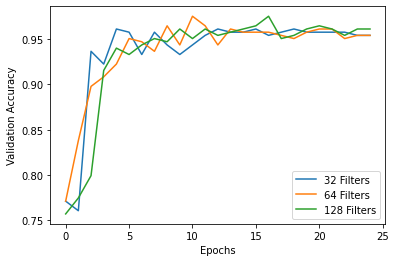

In [ ]:
plt.plot(history_CONV_1_32.history['val_accuracy'],label = str('32 Filters'))
plt.plot(history_CONV_1_64.history['val_accuracy'],label = str('64 Filters'))
plt.plot(history_CONV_1_128.history['val_accuracy'],label = str('128 Filters'))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend();